In [1]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import numpy as np
%matplotlib inline
torch.manual_seed(1)

In [12]:
class Data(Dataset):
    #  modified from: http://cs231n.github.io/neural-networks-case-study/
    def __init__(self, K, N):
        x = np.zeros((N * K, 2))
        y = np.zeros(N * K, dtype='uint8')
        for j in range(K):
            ix = range(N * j, N * (j + 1))
            r = np.linspace(0.0, 1.0, N)
            t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2
            x[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
            y[ix] = j
        self.y = torch.from_numpy(y).type(torch.LongTensor).view(-1)
        self.x = torch.from_numpy(x).type(torch.FloatTensor)
        self.len = y.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.len
    
    def plot_data(self):
        plt.plot(self.x[self.y[:] == 0, 0].numpy(), self.x[self.y[:] == 0, 1].numpy(), 'o', label="y = 0")
        plt.plot(self.x[self.y[:] == 1, 0].numpy(), self.x[self.y[:] == 1, 1].numpy(), 'ro', label="y = 1")
        plt.plot(self.x[self.y[:] == 2, 0].numpy(), self.x[self.y[:] == 2, 1].numpy(), 'go', label="y = 2")
        plt.legend()

In [2]:
class Net(nn.Module):
    def __init__(self, Layer_list, act_func): # Layer_list is a list of layer sizes
        super(Net, self).__init__()
        self.layers = nn.ModuleList() # Makes object of list of nn modules
        for i, input_size in enumerate(Layer_list[:-1]): # All but last layer size
            output_size = Layer_list[i + 1]
            if i < len(Layer_list) - 2:
                self.layers.append(nn.Sequential(nn.Linear(input_size, output_size), act_func))
            else: # If i is at the last hidden layer, do not apply act_func
                self.layers.append(nn.Linear(input_size, output_size))
            
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [7]:
def train_model(model, criterion, trainloader, optimizer, epochs):
    results_dict = {'epoch accuracy': [], 'batch loss': []}
    for epoch in range(epochs):
        epoch_loss = 0
        for x, y in trainloader:
            y_hat = model(x)
            loss = criterion(y_hat, y)
            results_dict['batch loss'].append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        results_dict['epoch accuracy'].append(accuracy(model, trainloader.dataset))
        
    return results_dict

In [34]:
def accuracy(model, dataset):
    y_hat = model(dataset.x)
    _, label = torch.max(y_hat, 1)
    return (label == dataset.y).numpy().mean()

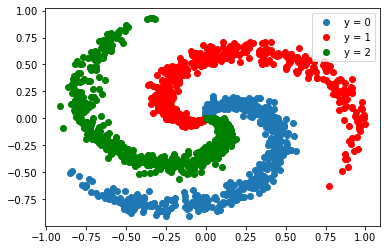

In [13]:
ds = Data(3, 500)
ds.plot_data()

In [47]:
model = Net([2, 50, 3], nn.ReLU()) # 1 Hidden Layer model w/ relu activation
optimizer = optim.SGD(model.parameters(), lr=0.1)
trainloader = DataLoader(ds, batch_size=20)
criterion = nn.CrossEntropyLoss()
results = train_model(model, criterion, trainloader, optimizer, 100)

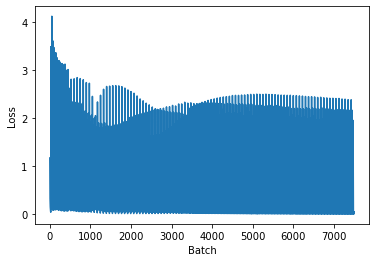

In [48]:
plt.plot(results['batch loss'])
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

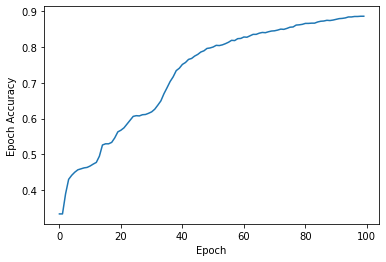

In [49]:
plt.plot(results['epoch accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Epoch Accuracy')
plt.show()

In [50]:
model2 = Net([2, 10, 10, 3], nn.ReLU()) # 2 Hidden Layers
optimizer2 = optim.SGD(model2.parameters(), lr=0.1)
results2 = train_model(model2, criterion, trainloader, optimizer2, 100)

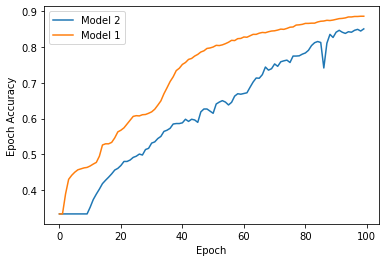

In [51]:
plt.plot(results2['epoch accuracy'], label='Model 2')
plt.plot(results['epoch accuracy'], label='Model 1')
plt.xlabel('Epoch')
plt.ylabel('Epoch Accuracy')
plt.legend()
plt.show()